# Group 11: Modeling Suspension and Expulsion Rates Based on Various School Demographic Information

We will attempt to predict whether a school has a high discipline rate (high suspension and expulsion rate) based on various factors including ethnicity, socioeconomic static, and absence rates

In [1]:
!pip3 install folium --upgrade
!pip3 install matplotlib
!pip3 install pandas
!pip3 install contextily
!pip3 install geopandas
!pip3 install chardet

In [2]:
#from datascience import *
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import folium
import json
import os
from branca.colormap import linear
import branca.colormap
import requests
from io import StringIO
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score

# Import any data cleaning libraries here

# Import your selected models here

# Import any other libraries here
from sklearn.model_selection import GridSearchCV

We obtain our datasets from https://www.cde.ca.gov/

In [75]:
# Import relevnt datasets
expulsion_data_url = 'https://www3.cde.ca.gov/demo-downloads/discipline/expulsion22-v3.txt'
absence_data_url = 'https://www3.cde.ca.gov/demo-downloads/attendance/chronicabsenteeism22-v2.txt'
suspension_data_url = 'https://www3.cde.ca.gov/demo-downloads/discipline/suspension22-v2.txt'

expulsion_data_url_2019 = 'https://www3.cde.ca.gov/demo-downloads/discipline/expulsion19.txt'
absence_data_url_2019 = 'https://www3.cde.ca.gov/demo-downloads/attendance/chronicabsenteeism19.txt'
suspension_data_url_2019 = 'https://www3.cde.ca.gov/demo-downloads/discipline/suspension19.txt'

# expulsion_data_url_2018 = 'https://www3.cde.ca.gov/demo-downloads/discipline/expulsion18.txt'
absence_data_url_2018 = 'https://www3.cde.ca.gov/demo-downloads/attendance/chronicabsenteeism18.txt'
# suspension_data_url_2018 = 'https://www3.cde.ca.gov/demo-downloads/discipline/suspension18.txt'

# Expulsion
response_expulsion = requests.get(expulsion_data_url)
response_expulsion.raise_for_status()

response_expulsion_2019 = requests.get(expulsion_data_url_2019)
response_expulsion_2019.raise_for_status()

# response_expulsion_2018 = requests.get(expulsion_data_url_2018)
# response_expulsion_2018.raise_for_status()

# Absence
response_absence = requests.get(absence_data_url)
response_absence.raise_for_status()

response_absence_2019 = requests.get(absence_data_url_2019)
response_absence_2019.raise_for_status()

response_absence_2018 = requests.get(absence_data_url_2018)
response_absence_2018.raise_for_status()

# Suspension
response_suspension = requests.get(suspension_data_url)
response_suspension.raise_for_status()

response_suspension_2019 = requests.get(suspension_data_url_2019)
response_suspension_2019.raise_for_status()

# response_suspension_2018 = requests.get(suspension_data_url_2018)
# response_suspension_2018.raise_for_status()

expulsion_data_2022 = pd.read_csv(StringIO(response_expulsion.text), sep='\t')
suspension_data_2022 = pd.read_csv(StringIO(response_suspension.text), sep='\t')
absence_data_2022 = pd.read_csv(StringIO(response_absence.text), sep='\t')
new_column_names = {col: col.replace(' ', '') for col in absence_data_2022.columns}
absence_data_2022 = absence_data_2022.rename(columns=new_column_names)

expulsion_data_2019 = pd.read_csv(StringIO(response_expulsion_2019.text), sep='\t')
expulsion_data_2019 = expulsion_data_2019.rename(columns={'Cumulative Enrollment': 'CumulativeEnrollment'}, 
                                                 inplace=False)
suspension_data_2019 = pd.read_csv(StringIO(response_suspension_2019.text), sep='\t')
absence_data_2019 = pd.read_csv(StringIO(response_absence_2019.text), sep='\t')

expulsion_data_2018 = pd.read_csv('data/expulsion18.csv')
suspension_data_2018 = pd.read_csv('data/suspension18.csv')
absence_data_2018 = pd.read_csv(StringIO(response_absence_2018.text), sep='\t')

expulsion_data_2017 = pd.read_csv('data/expulsion17.csv')
suspension_data_2017 = pd.read_csv('data/suspension17.csv')
absence_data_2017 = pd.read_csv('data/chronicabsenteeism17.csv')

expulsion_data = pd.concat([expulsion_data_2022, 
                            expulsion_data_2019, 
                            expulsion_data_2018,
                            expulsion_data_2017], ignore_index=True)
suspension_data = pd.concat([suspension_data_2022, 
                             suspension_data_2019, 
                             suspension_data_2018,
                             suspension_data_2017], ignore_index=True)
absence_data = pd.concat([absence_data_2022, 
                          absence_data_2019, 
                          absence_data_2018,
                          absence_data_2017], ignore_index=True)

We now convert colums to float types for computation, as well as removing any rows with '*'

In [76]:
expulsion_data_s = expulsion_data[expulsion_data['AggregateLevel']=='S']
expulsion_data_s.replace('*', '0', inplace=True)
expulsion_data_s_ta = expulsion_data_s[expulsion_data_s['ReportingCategory'] == 'TA']

columns_to_convert = [
    'Total Expulsions',
    'Unduplicated Count of Students Expelled (Total)',
    'Unduplicated Count of Students Expelled (Defiance-Only)',
    'Expulsion Rate (Total)',
    'Expulsion Count Violent Incident (Injury)',
    'Expulsion Count Violent Incident (No Injury)',
    'Expulsion Count Weapons Possession',
    'Expulsion Count Illicit Drug-Related',
    'Expulsion Count Defiance-Only',
    'Expulsion Count Other Reasons'
]

for column in columns_to_convert:
    expulsion_data_s[column] = expulsion_data_s[column].astype(float)
    
replacement_dict_expulsions = {
    'RB': 'African American',
    'RI': 'American Indian or Alaska Native',
    'RA': 'Asian',
    'RF': 'Filipino',
    'RH': 'Hispanic or Latino',
    'RD': 'Not Reported',
    'RP': 'Pacific Islander',
    'RT': 'Two or More Races',
    'RW': 'White',
    'GM': 'Male',
    'GF': 'Female',
    'GX': 'Non-Binary Gender (Beginning 2019–20)',
    'GZ': 'Missing Gender',
    'SE': 'English Learners',
    'SD': 'Students with Disabilities',
    'SS': 'Socioeconomically Disadvantaged',
    'SM': 'Migrant',
    'SF': 'Foster',
    'SH': 'Homeless'
}

expulsion_data_s['ReportingCategory'] = expulsion_data_s['ReportingCategory'].replace(replacement_dict_expulsions)

/var/folders/64/69_lqqy93wz576gl39ljxz5h0000gn/T/ipykernel_11165/3465200503.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expulsion_data_s.replace('*', '0', inplace=True)
/var/folders/64/69_lqqy93wz576gl39ljxz5h0000gn/T/ipykernel_11165/3465200503.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expulsion_data_s[column] = expulsion_data_s[column].astype(float)
/var/folders/64/69_lqqy93wz576gl39ljxz5h0000gn/T/ipykernel_11165/3465200503.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [77]:
absence_data_s = absence_data[absence_data['AggregateLevel'] == 'S']

replacement_dict_absence_data = {
    'RB': 'African American',
    'RI': 'American Indian or Alaska Native',
    'RA': 'Asian',
    'RF': 'Filipino',
    'RH': 'Hispanic or Latino',
    'RD': 'Did not Report',
    'RP': 'Pacific Islander',
    'RT': 'Two or More Races',
    'RW': 'White',
    'GM': 'Male',
    'GF': 'Female',
    'GX': 'Non-Binary Gender (Beginning 2019–20)',
    'GZ': 'Missing Gender',
    'SE': 'English Learners',
    'SD': 'Students with Disabilities',
    'SS': 'Socioeconomically Disadvantaged',
    'SM': 'Migrant',
    'SF': 'Foster',
    'SH': 'Homeless',
    'GRKN': 'Kindergarten (GRK prior to 2020–21)',
    'GR13': 'Grades 1–3',
    'GR46': 'Grades 4–6',
    'GR78': 'Grades 7–8',
    'GRK8': 'Grades K–8',
    'GR912': 'Grades 9–12',
    'GRUG': 'Ungraded Elementary and Secondary (Retired in 2017–18)'
}

absence_data_s['ReportingCategory'] = absence_data_s['ReportingCategory'].replace(replacement_dict_absence_data)
absence_data_s_condensed = absence_data_s[['AcademicYear',
                                           'SchoolName',
                                           'ReportingCategory', 
                                           'SchoolCode',
                                           'CharterSchool', 
                                           'ChronicAbsenteeismEligibleCumulativeEnrollment', 
                                           'ChronicAbsenteeismCount', 
                                           'ChronicAbsenteeismRate']]
absence_data_s_condensed['CharterSchool'] = absence_data_s_condensed['CharterSchool'].replace({'Yes': 1, 'No ': 0})
absence_data_s_condensed = absence_data_s_condensed.astype({'SchoolCode': 'int64'})

/var/folders/64/69_lqqy93wz576gl39ljxz5h0000gn/T/ipykernel_11165/1895802514.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  absence_data_s['ReportingCategory'] = absence_data_s['ReportingCategory'].replace(replacement_dict_absence_data)
/var/folders/64/69_lqqy93wz576gl39ljxz5h0000gn/T/ipykernel_11165/1895802514.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  absence_data_s_condensed['CharterSchool'] = absence_data_s_condensed['CharterSchool'].replace({'Yes': 1, 'No ': 0})


In [78]:
suspension_data_s = suspension_data[suspension_data['AggregateLevel']=='S']
suspension_data_s.replace('*', '0', inplace=True)
suspension_data_s_ta = suspension_data_s[suspension_data_s['ReportingCategory'] == 'TA']

columns_to_convert = [
    'Total Suspensions',
    'Unduplicated Count of Students Suspended (Total)',
    'Unduplicated Count of Students Suspended (Defiance-Only)',
    'Suspension Rate (Total)',
    'Suspension Count Violent Incident (Injury)',
    'Suspension Count Violent Incident (No Injury)',
    'Suspension Count Weapons Possession',
    'Suspension Count Illicit Drug-Related',
    'Suspension Count Defiance-Only',
    'Suspension Count Other Reasons'
]

for column in columns_to_convert:
    suspension_data_s[column] = suspension_data_s[column].astype(float)
    
replacement_dict_suspensions = {
    'RB': 'African American',
    'RI': 'American Indian or Alaska Native',
    'RA': 'Asian',
    'RF': 'Filipino',
    'RH': 'Hispanic or Latino',
    'RD': 'Not Reported',
    'RP': 'Pacific Islander',
    'RT': 'Two or More Races',
    'RW': 'White',
    'GM': 'Male',
    'GF': 'Female',
    'GX': 'Non-Binary Gender (Beginning 2019–20)',
    'GZ': 'Missing Gender',
    'SE': 'English Learners',
    'SD': 'Students with Disabilities',
    'SS': 'Socioeconomically Disadvantaged',
    'SM': 'Migrant',
    'SF': 'Foster',
    'SH': 'Homeless'
}

suspension_data_s['ReportingCategory'] = suspension_data_s['ReportingCategory'].replace(replacement_dict_suspensions)
suspension_data_s_condensed = suspension_data_s[
    [
    'AcademicYear',
    'SchoolName',
    'SchoolCode',
    'ReportingCategory', 
    'Total Suspensions',
    'Unduplicated Count of Students Suspended (Total)',
    'Unduplicated Count of Students Suspended (Defiance-Only)',
    'Suspension Rate (Total)',
    'Suspension Count Violent Incident (Injury)',
    'Suspension Count Violent Incident (No Injury)',
    'Suspension Count Weapons Possession',
    'Suspension Count Illicit Drug-Related',
    'Suspension Count Defiance-Only',
    'Suspension Count Other Reasons'
    ]
    ]
suspension_data_s_condensed = suspension_data_s_condensed.astype({'SchoolCode': 'int64'})

/var/folders/64/69_lqqy93wz576gl39ljxz5h0000gn/T/ipykernel_11165/444004829.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suspension_data_s.replace('*', '0', inplace=True)
/var/folders/64/69_lqqy93wz576gl39ljxz5h0000gn/T/ipykernel_11165/444004829.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suspension_data_s[column] = suspension_data_s[column].astype(float)
/var/folders/64/69_lqqy93wz576gl39ljxz5h0000gn/T/ipykernel_11165/444004829.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [79]:
# We add the academic year to the name of the school
suspension_data_s_condensed['SchoolName'] = suspension_data_s_condensed['SchoolName'] + suspension_data_s_condensed['AcademicYear'].astype(str)
expulsion_data_s['SchoolName'] = expulsion_data_s['SchoolName'] + expulsion_data_s['AcademicYear'].astype(str)
absence_data_s_condensed['SchoolName'] = absence_data_s_condensed['SchoolName'] + absence_data_s_condensed['AcademicYear'].astype(str)

/var/folders/64/69_lqqy93wz576gl39ljxz5h0000gn/T/ipykernel_11165/1025489938.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expulsion_data_s['SchoolName'] = expulsion_data_s['SchoolName'] + expulsion_data_s['AcademicYear'].astype(str)


### Join expulsion, suspension, and absence dataframes on Reporting category (male, female, etc.) and School Name

In [80]:
expulsion_absence_data = pd.merge(expulsion_data_s, 
                                  absence_data_s_condensed, 
                                  how='inner', 
                                  left_on=['ReportingCategory','SchoolName'], 
                                  right_on = ['ReportingCategory','SchoolName']
                                )
expulsion_absence_data.drop(['SchoolCode_y', 'CharterYN', 'AcademicYear_y'], axis=1, inplace=True)
expulsion_absence_data = expulsion_absence_data.drop_duplicates(['SchoolName', 'ReportingCategory'], 
                                                                keep='first')

merged_data = pd.merge(expulsion_absence_data, 
                          suspension_data_s_condensed, 
                          how='inner', 
                          left_on=['SchoolName','ReportingCategory'],
                          right_on=['SchoolName', 'ReportingCategory']
                        )
merged_data = merged_data.drop_duplicates(['SchoolName', 'ReportingCategory'], 
                                                                keep='first')
merged_data

,AcademicYear_x,AggregateLevel,CountyCode,DistrictCode,SchoolCode_x,CountyName,DistrictName,SchoolName,ReportingCategory,CumulativeEnrollment,...,Total Suspensions,Unduplicated Count of Students Suspended (Total),Unduplicated Count of Students Suspended (Defiance-Only),Suspension Rate (Total),Suspension Count Violent Incident (Injury),Suspension Count Violent Incident (No Injury),Suspension Count Weapons Possession,Suspension Count Illicit Drug-Related,Suspension Count Defiance-Only,Suspension Count Other Reasons
0,2021-22,S,1,10017.0,130419.0,Alameda,Alameda County Office of Education,Alameda County Community2021-22,Female,76,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-22,S,1,10017.0,130419.0,Alameda,Alameda County Office of Education,Alameda County Community2021-22,Male,28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-22,S,1,10017.0,130419.0,Alameda,Alameda County Office of Education,Alameda County Community2021-22,Asian,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-22,S,1,10017.0,130419.0,Alameda,Alameda County Office of Education,Alameda County Community2021-22,African American,27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-22,S,1,10017.0,130419.0,Alameda,Alameda County Office of Education,Alameda County Community2021-22,Filipino,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1074575,2016-17,S,58,72769.0,5838305.0,Yuba,Wheatland Union High,Wheatland Union High2016-17,Homeless,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1074577,2016-17,S,58,72769.0,123570.0,Yuba,Wheatland Union High,Wheatland Community Day High2016-17,Socioeconomically Disadvantaged,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1074579,2016-17,S,58,72769.0,5838305.0,Yuba,Wheatland Union High,Wheatland Union High2016-17,Socioeconomically Disadvantaged,324,...,63.0,40.0,17.0,12.3,0.0,30.0,0.0,5.0,20.0,8.0
1074581,2016-17,S,58,72769.0,123570.0,Yuba,Wheatland Union High,Wheatland Community Day High2016-17,TA,13,...,11.0,5.0,5.0,38.5,0.0,1.0,0.0,0.0,10.0,0.0


In [81]:
merged_data.groupby('AcademicYear_x').agg('count')

,AggregateLevel,CountyCode,DistrictCode,SchoolCode_x,CountyName,DistrictName,SchoolName,ReportingCategory,CumulativeEnrollment,Total Expulsions,...,Total Suspensions,Unduplicated Count of Students Suspended (Total),Unduplicated Count of Students Suspended (Defiance-Only),Suspension Rate (Total),Suspension Count Violent Incident (Injury),Suspension Count Violent Incident (No Injury),Suspension Count Weapons Possession,Suspension Count Illicit Drug-Related,Suspension Count Defiance-Only,Suspension Count Other Reasons
AcademicYear_x,,,,,,,,,,,,,,,,,,,,,
2016-17,127610,127610,127610,127610,127610,127610,127610,127610,127610,127610,...,127610,127610,127610,127610,127610,127610,127610,127610,127610,127610
2017-18,127830,127830,127830,127830,127830,127830,127830,127830,127830,127830,...,127830,127830,127830,127830,127830,127830,127830,127830,127830,127830
2018-19,127878,127878,127878,127878,127878,127878,127878,127878,127878,127878,...,127878,127878,127878,127878,127878,127878,127878,127878,127878,127878
2021-22,141044,141044,141044,141044,141044,141044,141044,141044,141044,141044,...,141044,141044,141044,141044,141044,141044,141044,141044,141044,141044


In [82]:
pivot_df = merged_data.pivot_table(index='SchoolName', 
                                   columns='ReportingCategory', 
                                   values='CumulativeEnrollment', 
                                   aggfunc='sum', fill_value=0)

pivot_df = pivot_df.astype(float)
pivot_df.reset_index(inplace = True)
pivot_df

ReportingCategory,SchoolName,African American,American Indian or Alaska Native,Asian,English Learners,Female,Filipino,Foster,Hispanic or Latino,Homeless,Male,Migrant,Non-Binary Gender (Beginning 2019–20),Pacific Islander,Socioeconomically Disadvantaged,Students with Disabilities,TA,Two or More Races,White
0,138th Street2021-22,34.0,0.0,18.0,61.0,216.0,12.0,0.0,249.0,0.0,237.0,0.0,0.0,0.0,169.0,82.0,453.0,55.0,82.0
1,21st Century Learning Institute2016-17,14.0,0.0,0.0,0.0,85.0,0.0,0.0,82.0,0.0,84.0,0.0,0.0,0.0,100.0,0.0,169.0,0.0,68.0
2,21st Century Learning Institute2017-18,16.0,0.0,0.0,12.0,90.0,0.0,0.0,87.0,0.0,79.0,0.0,0.0,0.0,112.0,15.0,169.0,0.0,60.0
3,21st Century Learning Institute2018-19,14.0,1.0,3.0,15.0,97.0,1.0,1.0,101.0,0.0,77.0,0.0,0.0,0.0,110.0,14.0,174.0,4.0,49.0
4,21st Century Learning Institute2021-22,70.0,0.0,16.0,52.0,361.0,29.0,0.0,400.0,0.0,358.0,0.0,0.0,0.0,439.0,83.0,721.0,37.0,158.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34949,iQ Academy California-Los Angeles2021-22,337.0,17.0,45.0,114.0,800.0,48.0,0.0,787.0,38.0,749.0,0.0,0.0,11.0,1145.0,221.0,1549.0,22.0,276.0
34950,one.Charter2016-17,82.0,0.0,13.0,26.0,167.0,0.0,15.0,180.0,50.0,193.0,0.0,0.0,0.0,317.0,26.0,360.0,23.0,56.0
34951,one.Charter2017-18,161.0,12.0,27.0,89.0,379.0,0.0,32.0,402.0,98.0,377.0,0.0,0.0,0.0,664.0,49.0,756.0,40.0,98.0
34952,one.Charter2018-19,199.0,17.0,51.0,149.0,686.0,12.0,49.0,729.0,151.0,538.0,1.0,0.0,5.0,1063.0,26.0,1224.0,61.0,134.0


In [83]:
# Divide each category by the total enrollment of the school
columns_to_normalize = [col for col in pivot_df.columns if col not in ['SchoolName', 'TA']]

# Divide each column by the 'TA' column
for col in columns_to_normalize:
    pivot_df[col] = pivot_df[col] / pivot_df['TA']
    
# Normalize 'TA' column

# Calculate the mean and standard deviation of the 'TA' column
mean_TA = pivot_df['TA'].mean()
std_TA = pivot_df['TA'].std()

pivot_df['TA_normalized'] = (pivot_df['TA'] - mean_TA) / std_TA
pivot_df = pivot_df.drop('TA', axis = 1)
pivot_df

ReportingCategory,SchoolName,African American,American Indian or Alaska Native,Asian,English Learners,Female,Filipino,Foster,Hispanic or Latino,Homeless,Male,Migrant,Non-Binary Gender (Beginning 2019–20),Pacific Islander,Socioeconomically Disadvantaged,Students with Disabilities,Two or More Races,White,TA_normalized
0,138th Street2021-22,0.075055,0.000000,0.039735,0.134658,0.476821,0.026490,0.000000,0.549669,0.000000,0.523179,0.000000,0.0,0.000000,0.373068,0.181015,0.121413,0.181015,-0.353284
1,21st Century Learning Institute2016-17,0.082840,0.000000,0.000000,0.000000,0.502959,0.000000,0.000000,0.485207,0.000000,0.497041,0.000000,0.0,0.000000,0.591716,0.000000,0.000000,0.402367,-0.800439
2,21st Century Learning Institute2017-18,0.094675,0.000000,0.000000,0.071006,0.532544,0.000000,0.000000,0.514793,0.000000,0.467456,0.000000,0.0,0.000000,0.662722,0.088757,0.000000,0.355030,-0.800439
3,21st Century Learning Institute2018-19,0.080460,0.005747,0.017241,0.086207,0.557471,0.005747,0.005747,0.580460,0.000000,0.442529,0.000000,0.0,0.000000,0.632184,0.080460,0.022989,0.281609,-0.792567
4,21st Century Learning Institute2021-22,0.097087,0.000000,0.022191,0.072122,0.500693,0.040222,0.000000,0.554785,0.000000,0.496533,0.000000,0.0,0.000000,0.608877,0.115118,0.051318,0.219140,0.068679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34949,iQ Academy California-Los Angeles2021-22,0.217560,0.010975,0.029051,0.073596,0.516462,0.030988,0.000000,0.508070,0.024532,0.483538,0.000000,0.0,0.007101,0.739187,0.142673,0.014203,0.178179,1.372356
34950,one.Charter2016-17,0.227778,0.000000,0.036111,0.072222,0.463889,0.000000,0.041667,0.500000,0.138889,0.536111,0.000000,0.0,0.000000,0.880556,0.072222,0.063889,0.155556,-0.499712
34951,one.Charter2017-18,0.212963,0.015873,0.035714,0.117725,0.501323,0.000000,0.042328,0.531746,0.129630,0.498677,0.000000,0.0,0.000000,0.878307,0.064815,0.052910,0.129630,0.123786
34952,one.Charter2018-19,0.162582,0.013889,0.041667,0.121732,0.560458,0.009804,0.040033,0.595588,0.123366,0.439542,0.000817,0.0,0.004085,0.868464,0.021242,0.049837,0.109477,0.860647


In [84]:
merged_data_ta = merged_data[merged_data['ReportingCategory'] == 'TA']
merged_data_ta['DisciplineRate'] = merged_data_ta['Suspension Rate (Total)'] + 5*merged_data_ta['Expulsion Rate (Total)']
merged_data_ta_selected_cols = merged_data_ta[[
    'SchoolName',
    'ChronicAbsenteeismRate',
    'DisciplineRate',
]]
merged_data_ta_selected_cols

/var/folders/64/69_lqqy93wz576gl39ljxz5h0000gn/T/ipykernel_11165/2028611687.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_ta['DisciplineRate'] = merged_data_ta['Suspension Rate (Total)'] + 5*merged_data_ta['Expulsion Rate (Total)']


,SchoolName,ChronicAbsenteeismRate,DisciplineRate
15,Alameda County Community2021-22,78.7,0.0
31,Alameda County Juvenile Hall/Court2021-22,63.9,0.6
47,Alternatives in Action2021-22,42.5,0.0
63,Aurum Preparatory Academy2021-22,26.4,7.0
79,Community School for Creative Education2021-22,62.1,0.9
...,...,...,...
1074531,Bear River2016-17,5.3,9.2
1074533,Wheatland Elementary2016-17,7.1,0.6
1074535,Wheatland Charter Academy2016-17,2.9,0.9
1074581,Wheatland Community Day High2016-17,55.6,38.5


In [85]:
train_test_data = pd.merge(merged_data_ta_selected_cols, 
                                  pivot_df, 
                                  how='inner', 
                                  left_on='SchoolName', 
                                  right_on = 'SchoolName'
                                )
train_test_data = train_test_data.drop_duplicates(['SchoolName'], keep='first').drop('SchoolName', axis = 1)
train_test_data

,ChronicAbsenteeismRate,DisciplineRate,African American,American Indian or Alaska Native,Asian,English Learners,Female,Filipino,Foster,Hispanic or Latino,Homeless,Male,Migrant,Non-Binary Gender (Beginning 2019–20),Pacific Islander,Socioeconomically Disadvantaged,Students with Disabilities,Two or More Races,White,TA_normalized
0,78.7,0.0,0.259615,0.000000,0.000000,0.298077,0.730769,0.0,0.000000,0.605769,0.000000,0.269231,0.0,0.0,0.0,0.846154,0.144231,0.000000,0.000000,-0.902781
1,63.9,0.6,0.581267,0.000000,0.000000,0.129477,0.159780,0.0,0.250689,0.300275,0.168044,0.840220,0.0,0.0,0.0,1.000000,0.275482,0.000000,0.038567,-0.494988
2,42.5,0.0,0.064171,0.000000,0.000000,0.582888,0.540107,0.0,0.000000,0.893048,0.064171,0.459893,0.0,0.0,0.0,0.898396,0.144385,0.000000,0.000000,-0.772098
3,26.4,7.0,0.381720,0.000000,0.000000,0.317204,0.451613,0.0,0.000000,0.575269,0.000000,0.548387,0.0,0.0,0.0,0.892473,0.177419,0.000000,0.000000,-0.773673
4,62.1,0.9,0.159292,0.000000,0.101770,0.504425,0.469027,0.0,0.000000,0.610619,0.000000,0.530973,0.0,0.0,0.0,0.867257,0.207965,0.048673,0.000000,-0.710693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34949,5.3,9.2,0.036913,0.020134,0.036913,0.038591,0.461409,0.0,0.000000,0.204698,0.020134,0.538591,0.0,0.0,0.0,0.474832,0.109060,0.077181,0.607383,-0.128132
34950,7.1,0.6,0.000000,0.000000,0.000000,0.100000,0.487879,0.0,0.000000,0.278788,0.069697,0.512121,0.0,0.0,0.0,0.527273,0.118182,0.075758,0.606061,-0.546946
34951,2.9,0.9,0.000000,0.000000,0.000000,0.000000,0.491071,0.0,0.000000,0.205357,0.000000,0.508929,0.0,0.0,0.0,0.491071,0.133929,0.098214,0.553571,-0.890185
34952,55.6,38.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,-1.046059


### Further cleaning

In [86]:
train_test_data = train_test_data[train_test_data.applymap(lambda x: x != '*').all(axis=1)]

train_test_data

,ChronicAbsenteeismRate,DisciplineRate,African American,American Indian or Alaska Native,Asian,English Learners,Female,Filipino,Foster,Hispanic or Latino,Homeless,Male,Migrant,Non-Binary Gender (Beginning 2019–20),Pacific Islander,Socioeconomically Disadvantaged,Students with Disabilities,Two or More Races,White,TA_normalized
0,78.7,0.0,0.259615,0.000000,0.000000,0.298077,0.730769,0.0,0.000000,0.605769,0.000000,0.269231,0.0,0.0,0.0,0.846154,0.144231,0.000000,0.000000,-0.902781
1,63.9,0.6,0.581267,0.000000,0.000000,0.129477,0.159780,0.0,0.250689,0.300275,0.168044,0.840220,0.0,0.0,0.0,1.000000,0.275482,0.000000,0.038567,-0.494988
2,42.5,0.0,0.064171,0.000000,0.000000,0.582888,0.540107,0.0,0.000000,0.893048,0.064171,0.459893,0.0,0.0,0.0,0.898396,0.144385,0.000000,0.000000,-0.772098
3,26.4,7.0,0.381720,0.000000,0.000000,0.317204,0.451613,0.0,0.000000,0.575269,0.000000,0.548387,0.0,0.0,0.0,0.892473,0.177419,0.000000,0.000000,-0.773673
4,62.1,0.9,0.159292,0.000000,0.101770,0.504425,0.469027,0.0,0.000000,0.610619,0.000000,0.530973,0.0,0.0,0.0,0.867257,0.207965,0.048673,0.000000,-0.710693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34949,5.3,9.2,0.036913,0.020134,0.036913,0.038591,0.461409,0.0,0.000000,0.204698,0.020134,0.538591,0.0,0.0,0.0,0.474832,0.109060,0.077181,0.607383,-0.128132
34950,7.1,0.6,0.000000,0.000000,0.000000,0.100000,0.487879,0.0,0.000000,0.278788,0.069697,0.512121,0.0,0.0,0.0,0.527273,0.118182,0.075758,0.606061,-0.546946
34951,2.9,0.9,0.000000,0.000000,0.000000,0.000000,0.491071,0.0,0.000000,0.205357,0.000000,0.508929,0.0,0.0,0.0,0.491071,0.133929,0.098214,0.553571,-0.890185
34952,55.6,38.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,-1.046059


Here, we do a preliminary analysis of the distribution of discipline rates

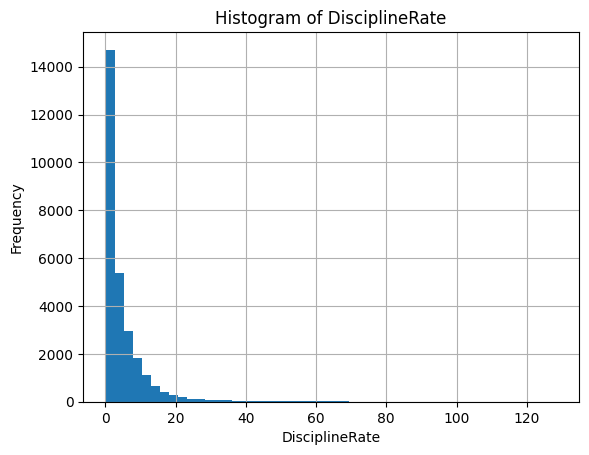

In [87]:
# Plot a histogram of the 'DisciplineRate' column
train_test_data[train_test_data['DisciplineRate'] > 0]['DisciplineRate'].hist(bins=50)

# Add labels and title
plt.xlabel('DisciplineRate')
plt.ylabel('Frequency')
plt.title('Histogram of DisciplineRate')

# Show the plot
plt.show()

We now form a threshold for what constitutes 'high discipline'. In our case, we selected a threshold that roughly divides the data in half (i.e. half are not 'high discipline', half are)

In [89]:
from sklearn.preprocessing import MinMaxScaler

# Create the 'IsDisciplineHigh' column
train_test_data['IsDisciplineHigh'] = train_test_data['DisciplineRate'].apply(lambda x: 1 if x > 1 else 0)

# Drop the 'DisciplineRate' column
train_test_data_normalized_binary = train_test_data.drop('DisciplineRate', axis=1)
train_test_data_normalized_binary

/var/folders/64/69_lqqy93wz576gl39ljxz5h0000gn/T/ipykernel_11165/1481594262.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_test_data['IsDisciplineHigh'] = train_test_data['DisciplineRate'].apply(lambda x: 1 if x > 1 else 0)


,ChronicAbsenteeismRate,African American,American Indian or Alaska Native,Asian,English Learners,Female,Filipino,Foster,Hispanic or Latino,Homeless,Male,Migrant,Non-Binary Gender (Beginning 2019–20),Pacific Islander,Socioeconomically Disadvantaged,Students with Disabilities,Two or More Races,White,TA_normalized,IsDisciplineHigh
0,78.7,0.259615,0.000000,0.000000,0.298077,0.730769,0.0,0.000000,0.605769,0.000000,0.269231,0.0,0.0,0.0,0.846154,0.144231,0.000000,0.000000,-0.902781,0
1,63.9,0.581267,0.000000,0.000000,0.129477,0.159780,0.0,0.250689,0.300275,0.168044,0.840220,0.0,0.0,0.0,1.000000,0.275482,0.000000,0.038567,-0.494988,0
2,42.5,0.064171,0.000000,0.000000,0.582888,0.540107,0.0,0.000000,0.893048,0.064171,0.459893,0.0,0.0,0.0,0.898396,0.144385,0.000000,0.000000,-0.772098,0
3,26.4,0.381720,0.000000,0.000000,0.317204,0.451613,0.0,0.000000,0.575269,0.000000,0.548387,0.0,0.0,0.0,0.892473,0.177419,0.000000,0.000000,-0.773673,1
4,62.1,0.159292,0.000000,0.101770,0.504425,0.469027,0.0,0.000000,0.610619,0.000000,0.530973,0.0,0.0,0.0,0.867257,0.207965,0.048673,0.000000,-0.710693,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34949,5.3,0.036913,0.020134,0.036913,0.038591,0.461409,0.0,0.000000,0.204698,0.020134,0.538591,0.0,0.0,0.0,0.474832,0.109060,0.077181,0.607383,-0.128132,1
34950,7.1,0.000000,0.000000,0.000000,0.100000,0.487879,0.0,0.000000,0.278788,0.069697,0.512121,0.0,0.0,0.0,0.527273,0.118182,0.075758,0.606061,-0.546946,0
34951,2.9,0.000000,0.000000,0.000000,0.000000,0.491071,0.0,0.000000,0.205357,0.000000,0.508929,0.0,0.0,0.0,0.491071,0.133929,0.098214,0.553571,-0.890185,0
34952,55.6,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,-1.046059,1


In [90]:
# remove all NaN rows
train_test_data_normalized_binary.dropna(inplace=True)

In [91]:
train_test_data_normalized_binary

,ChronicAbsenteeismRate,African American,American Indian or Alaska Native,Asian,English Learners,Female,Filipino,Foster,Hispanic or Latino,Homeless,Male,Migrant,Non-Binary Gender (Beginning 2019–20),Pacific Islander,Socioeconomically Disadvantaged,Students with Disabilities,Two or More Races,White,TA_normalized,IsDisciplineHigh
0,78.7,0.259615,0.000000,0.000000,0.298077,0.730769,0.0,0.000000,0.605769,0.000000,0.269231,0.0,0.0,0.0,0.846154,0.144231,0.000000,0.000000,-0.902781,0
1,63.9,0.581267,0.000000,0.000000,0.129477,0.159780,0.0,0.250689,0.300275,0.168044,0.840220,0.0,0.0,0.0,1.000000,0.275482,0.000000,0.038567,-0.494988,0
2,42.5,0.064171,0.000000,0.000000,0.582888,0.540107,0.0,0.000000,0.893048,0.064171,0.459893,0.0,0.0,0.0,0.898396,0.144385,0.000000,0.000000,-0.772098,0
3,26.4,0.381720,0.000000,0.000000,0.317204,0.451613,0.0,0.000000,0.575269,0.000000,0.548387,0.0,0.0,0.0,0.892473,0.177419,0.000000,0.000000,-0.773673,1
4,62.1,0.159292,0.000000,0.101770,0.504425,0.469027,0.0,0.000000,0.610619,0.000000,0.530973,0.0,0.0,0.0,0.867257,0.207965,0.048673,0.000000,-0.710693,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34949,5.3,0.036913,0.020134,0.036913,0.038591,0.461409,0.0,0.000000,0.204698,0.020134,0.538591,0.0,0.0,0.0,0.474832,0.109060,0.077181,0.607383,-0.128132,1
34950,7.1,0.000000,0.000000,0.000000,0.100000,0.487879,0.0,0.000000,0.278788,0.069697,0.512121,0.0,0.0,0.0,0.527273,0.118182,0.075758,0.606061,-0.546946,0
34951,2.9,0.000000,0.000000,0.000000,0.000000,0.491071,0.0,0.000000,0.205357,0.000000,0.508929,0.0,0.0,0.0,0.491071,0.133929,0.098214,0.553571,-0.890185,0
34952,55.6,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,-1.046059,1


In [92]:
# Separate the features and target variable
X = train_test_data_normalized_binary.drop('IsDisciplineHigh', axis=1)
y = train_test_data_normalized_binary['IsDisciplineHigh']

# Split the data into a 70% training set and 30% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Creating a baseline model

In [93]:
# Create a baseline model that predicts 0 for all instances in the test set
baseline_pred = np.zeros(y_test.shape)

# Calculate the accuracy of the baseline model
baseline_accuracy = accuracy_score(y_test, baseline_pred)

print("Baseline Accuracy Score:")
print(baseline_accuracy)

Baseline Accuracy Score:
0.4145040369088812


In [94]:
# Create a baseline model that predicts 1 for all instances in the test set
baseline_pred_ones = np.ones(y_test.shape)

# Calculate the accuracy of the baseline model
baseline_accuracy_ones = accuracy_score(y_test, baseline_pred_ones)

print("Baseline Accuracy Score (All Ones):")
print(baseline_accuracy_ones)

Baseline Accuracy Score (All Ones):
0.5854959630911188


## Model Selection

We now use random forest and MLP from scikitlearn, since they are extremely solid choices for classification problems

We chose a Random Forest Model (ensemble learning methods) because that combines multiple decision trees to produce a more accurate and stable prediction as we can see from the large increase in accuracy score. Random forests are also able to handle a mixture of continuous and categorical variables, which we found would make them better suited for our dataset with a mix of data types. The accuracy score of the random forest model we trained, which is 0.76, is significantly higher than the baseline accuracy score and therefore shows that the model is performing better than random chance. However, there is still room for improvement, and we can try to tune the model's hyperparameters to increase its performance. We also evaluated the Accuracy Score of other types of models including AdaBoost and Linear Regression models (linear regressions are not a good fit for this data) which we have displayed at the very end.

In [101]:
# Create and fit the Random Forest model
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = model_rf.predict(X_test)

# Output the results
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Accuracy Score of random forest:")
print(accuracy_score(y_test, y_pred_rf))

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.66      0.69      2875
           1       0.77      0.81      0.79      4061

    accuracy                           0.75      6936
   macro avg       0.74      0.74      0.74      6936
weighted avg       0.75      0.75      0.75      6936

Accuracy Score of random forest:
0.7488465974625144


In [96]:
# Get the feature importances
importances = model_rf.feature_importances_

# Get the indices of the top 5 most important features
top5_indices = np.argsort(importances)[-5:]

# Print the top 5 most important features and their importance ratings
print("Top 5 most important features:")
for index in top5_indices[::-1]:
    print(f"{X_train.columns[index]}: {importances[index]}")

Top 5 most important features:
TA_normalized: 0.10505616291894256
ChronicAbsenteeismRate: 0.09643514229102082
Socioeconomically Disadvantaged: 0.09065965947661378
Hispanic or Latino: 0.07543108353613334
English Learners: 0.07380198553817834


In [97]:
# Tune model
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create the Random Forest model
model_rf = RandomForestClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:")
print(best_params)

# Train the model with the best parameters
best_model_rf = RandomForestClassifier(**best_params, random_state=42)
best_model_rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = best_model_rf.predict(X_test)

# Output the results
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred_rf))

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best Parameters:
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.68      0.70      2875
           1       0.78      0.82      0.80      4061

    accuracy                           0.76      6936
   macro avg       0.76      0.75      0.75      6936
weighted avg       0.76      0.76      0.76      6936

Accuracy Score:
0.7616782006920415


In [102]:
# Make predictions on the test set based on tuned model
y_pred_rf_tuned = best_model_rf.predict(X_test)

# Output the results
print("Classification Report:")
print(classification_report(y_test, y_pred_rf_tuned))
print("Accuracy Score of tuned random forest predictor:")
print(accuracy_score(y_test, y_pred_rf_tuned))

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.68      0.70      2875
           1       0.78      0.82      0.80      4061

    accuracy                           0.76      6936
   macro avg       0.76      0.75      0.75      6936
weighted avg       0.76      0.76      0.76      6936

Accuracy Score of tuned random forest predictor:
0.7616782006920415


In [107]:
# Calculate the confusion matrix of rf predictor
conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Extract true negatives (TN), false positives (FP), false negatives (FN), and true positives (TP)
TN, FP, FN, TP = conf_matrix.ravel()

# Calculate the false positive rate (FPR), false negative rate (FNR), true positive rate (TPR), and true negative rate (TNR)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
TPR = TP / (TP + FN)
TNR = TN / (TN + FP)

print(f"False Positive Rate (FPR): {FPR * 100:.2f}%")
print(f"False Negative Rate (FNR): {FNR * 100:.2f}%")
print(f"True Positive Rate (TPR): {TPR * 100:.2f}%")
print(f"True Negative Rate (TNR): {TNR * 100:.2f}%")

False Positive Rate (FPR): 33.60%
False Negative Rate (FNR): 19.11%
True Positive Rate (TPR): 80.89%
True Negative Rate (TNR): 66.40%


So far, as mentioned above, our tuned random forest classifier scored the highest in accuracy with test data at above 76.16% accuracy. The model does have a higher false positive rate versus false negative rate.

## OTHER MODELS

In [99]:
# Initialize the MLP classifier
mlp_model = MLPClassifier(random_state=42)

# Fit the model to the training data
mlp_model.fit(X_train, y_train)

# Predict labels for the test set
mlp_pred = mlp_model.predict(X_test)

# Calculate the accuracy of the MLP model
mlp_accuracy = accuracy_score(y_test, mlp_pred)

# Print the accuracy and other metrics for the MLP model
print("MLP Accuracy Score:")
print(mlp_accuracy)
print("\nClassification Report:")
print(classification_report(y_test, mlp_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, mlp_pred))

MLP Accuracy Score:
0.7145328719723183

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.64      0.65      2875
           1       0.75      0.76      0.76      4061

    accuracy                           0.71      6936
   macro avg       0.71      0.70      0.70      6936
weighted avg       0.71      0.71      0.71      6936


Confusion Matrix:
[[1851 1024]
 [ 956 3105]]


/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Ensemble Methods

In [103]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}

# Create an instance of the AdaBoostClassifier
model_ab = AdaBoostClassifier(random_state=42)

# Create an instance of GridSearchCV
grid_search_ab = GridSearchCV(estimator=model_ab, 
                              param_grid=param_grid, 
                              cv=5, 
                              scoring='accuracy')

# Fit the GridSearchCV instance to the training data
grid_search_ab.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:")
print(grid_search_ab.best_params_)

# Make predictions on the test set using the best model
best_model_ab = grid_search_ab.best_estimator_
y_pred_ab = best_model_ab.predict(X_test)

# Output the results
print("Classification Report:")
print(classification_report(y_test, y_pred_ab))
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred_ab))

KeyboardInterrupt: 

Linear Regression

In [104]:
from sklearn.linear_model import LinearRegression

# Create and fit the linear regression model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lr = model_lr.predict(X_test)

# Convert the predicted probabilities to binary predictions (0 or 1)
y_pred_lr_binary = [1 if pred > 0.5 else 0 for pred in y_pred_lr]

# Output the results
print("Classification Report:")
print(classification_report(y_test, y_pred_lr_binary))
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred_lr_binary))

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.43      0.51      2875
           1       0.67      0.82      0.74      4061

    accuracy                           0.66      6936
   macro avg       0.65      0.62      0.62      6936
weighted avg       0.65      0.66      0.64      6936

Accuracy Score:
0.657439446366782


Ridge Model

In [105]:
from sklearn.linear_model import Ridge
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the Ridge model
model_ridge = Ridge(alpha=0.1)
model_ridge.fit(X_train, y_train)

# Make predictions on the test set
y_pred_ridge = model_ridge.predict(X_test)

# Convert predicted probabilities to binary values
y_pred_ridge_binary = [1 if x > 0.5 else 0 for x in y_pred_ridge]

# Output the results
print("Classification Report:")
print(classification_report(y_test, y_pred_ridge_binary))
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred_ridge_binary))

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.43      0.51      2875
           1       0.67      0.82      0.74      4061

    accuracy                           0.66      6936
   macro avg       0.65      0.62      0.62      6936
weighted avg       0.65      0.66      0.64      6936

Accuracy Score:
0.657439446366782


Lasso Model

In [106]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import math

# Create and fit the Lasso model
model_lasso = Lasso(alpha=0.1)
model_lasso.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lasso = model_lasso.predict(X_test)

# Calculate the mean squared error
mse_lasso = mean_squared_error(y_test, y_pred_lasso)

print("Mean Squared Error:")
print(mse_lasso)

y_pred_lasso = model_lasso.predict(X_test)
mse = mean_squared_error(y_test, y_pred_lasso)
rmse = math.sqrt(mse)

print("Root Mean Squared Error:")
print(rmse)

Mean Squared Error:
0.24023146587466637
Root Mean Squared Error:
0.49013413049354804


## Modeling Results Explanation

Based on the models that were trained on the given data, we can predict with some accuracy whether a school has a high discipline rate (suspension and expulsion). The random forest model achieved the highest accuracy of 0.72 and the logistic regression model with an accuracy of 0.61.

The random forest model was able to achieve the highest accuracy by using an ensemble of decision trees to make predictions. It takes into account a larger number of factors and can handle non-linear relationships between the predictor variables and the response variable. By using the feature importance metric provided by the model, we can identify which features were most important in predicting the outcome. In this case, it seems that ethnicity and socioeconomic status were the most important features in predicting high discipline rates.

The logistic regression model achieved the lowest accuracy out of the models. This model assumes a linear relationship between the predictor variables and the response variable, which may not be appropriate in this case since the relationship between the predictors and the response variable may be non-linear. However, it can still provide some insights into which features are most important in predicting high discipline rates.

Overall, the models suggest that factors such as ethnicity and socioeconomic status are important predictors of high discipline rates in schools. These findings can be used to inform policies and interventions aimed at reducing discipline rates and promoting more equitable school environments.